In [1]:

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
 
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
 
AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

2024-06-13 07:29:17.082370: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 07:29:17.336021: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 07:29:17.337243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 07:29:18.517374: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:

images = glob('data/*/*.jpg')
len(images)

698

In [24]:
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()

,filepath,label
0,data/ISIC-malignant/ISIC_0024301.jpg,ISIC-malignant
1,data/ISIC-malignant/ISIC_7957576.jpg,ISIC-malignant
2,data/ISIC-malignant/ISIC_0024261.jpg,ISIC-malignant
3,data/ISIC-malignant/ISIC_0024252.jpg,ISIC-malignant
4,data/ISIC-malignant/ISIC_6889410.jpg,ISIC-malignant


In [23]:
df['label'] = df['label'].str.replace('ISIC-', '')
#df.head(50)

random_sample = df.sample(n=25)
print(random_sample)

                                 filepath      label  label_bin
420     data/ISIC-benign/ISIC_0520507.jpg     benign          0
194  data/ISIC-malignant/ISIC_0024269.jpg  malignant          1
58   data/ISIC-malignant/ISIC_0211418.jpg  malignant          1
586                data/malignant/267.jpg  malignant          1
508                data/malignant/217.jpg  malignant          1
542                data/malignant/113.jpg  malignant          1
200  data/ISIC-malignant/ISIC_1640110.jpg  malignant          1
310     data/ISIC-benign/ISIC_9497941.jpg     benign          0
276  data/ISIC-malignant/ISIC_3098914.jpg  malignant          1
299                    data/benign/13.jpg     benign          0
87   data/ISIC-malignant/ISIC_5815174.jpg  malignant          1
307                    data/benign/14.jpg     benign          0
524                 data/malignant/49.jpg  malignant          1
529                data/malignant/291.jpg  malignant          1
56   data/ISIC-malignant/ISIC_6584700.jp

In [17]:

df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)

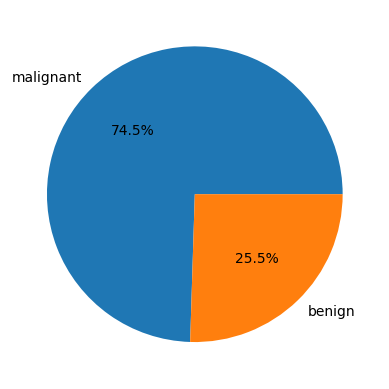

In [18]:

x = df['label'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()


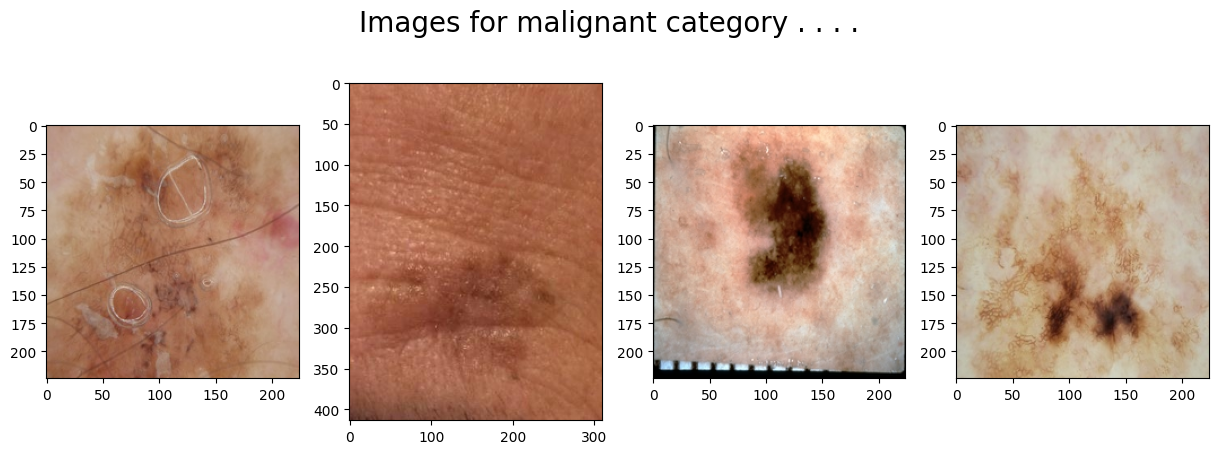

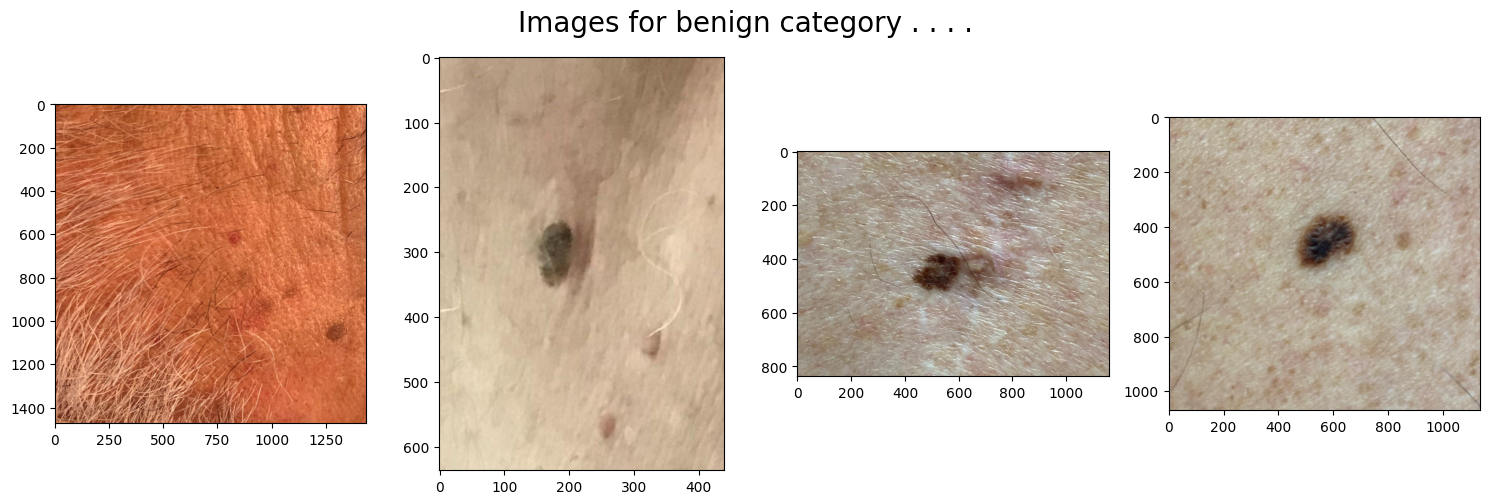

In [19]:

for cat in df['label'].unique():
    temp = df[df['label'] == cat]
 
    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]
 
        image_path = data[0]
 
        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()


In [20]:

features = df['filepath']
target = df['label_bin']
 
X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)
 
X_train.shape, X_val.shape


((593,), (105,))

In [32]:

def decode_image(filepath, label=None):
 
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0

    # print('label:', label)
    # if label == 'benign':
    #     Label = 0
    # else:
    #     Label = 1
 
    #return img, Label
    return img



In [33]:

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)
 
val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


In [34]:


from tensorflow.keras.applications.efficientnet import EfficientNetB7
 
pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)
 
for layer in pre_trained_model.layers:
    layer.trainable = False


258076736/258076736 [==============================] - 5s 0us/step


In [35]:

from tensorflow.keras import Model
 
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)
 
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
 
model = Model(inputs, outputs)


In [36]:

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['AUC']
)


In [37]:

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    verbose=1)


Epoch 1/5


ValueError: in user code:

    File "/home/funda/Projects/ML-projects/winefore/ML-env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/funda/Projects/ML-projects/winefore/ML-env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/funda/Projects/ML-projects/winefore/ML-env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/funda/Projects/ML-projects/winefore/ML-env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1082, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/funda/Projects/ML-projects/winefore/ML-env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1036, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=<keras.src.losses.BinaryCrossentropy object at 0x7f9500ae1d30>, and therefore expects target data to be provided in `fit()`.


In [38]:

hist_df = pd.DataFrame(history.history)
hist_df.head()


NameError: name 'history' is not defined